# Gravitational orbit using Lagrange's equation
Using solve.ivp and leapfrog methods to solve the problem.

## Euler-Lagrange equation

For this system, the Lagrangian is:

\begin{align}
  \mathcal{L} = \frac12 m_1 (\dot x_1 ^2 + \dot y_1 ^2) + \frac12 m_1 (\dot x_2 ^2 + \dot y_2 ^2)\
  + \frac{G m_1 m_2} {\sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}}
\end{align}

The Euler-Lagrange equations gives us:

\begin{align}
 \ddot x_1 = \frac {G m_2} {\sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}^3} (x_2 - x_1)
  \;.
\end{align}
\begin{align}
  \ddot y_1 = \frac {G m_2} {\sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}^3} (y_2 - y_1)
  \;.
\end{align}
\begin{align}
 \ddot x_2 = -\frac {G m_1} {\sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}^3} (x_2 - x_1)
  \;.
\end{align}
\begin{align}
 \ddot y_2 = -\frac {G m_1} {\sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}^3} (y_2 - y_1)
  \;.
\end{align}

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.integrate import odeint, solve_ivp

import matplotlib.pyplot as plt

In [3]:
# The dpi (dots-per-inch) setting will affect the resolution and how large
#  the plots appear on screen and printed.  So you may want/need to adjust 
#  the figsize when creating the figure.
plt.rcParams['figure.dpi'] = 100.    # this is the default for notebook

# Change the common font size (smaller when higher dpi)
font_size = 10
plt.rcParams.update({'font.size': font_size})

## Orbit class and two methods

In [4]:
class Orbit():
    """
    Orbit class implements the parameters and Lagrange's equations for 
     a simple pendulum (no driving or damping).
     
    Parameters
    ----------
    m1 : float
        mass of first body
    m2 : float
        mass of second body
    G : float
        gravitational constant

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    def __init__(self, m1=1., m2=1., G=1.):
        self.m1 = m1
        self.m2 = m2
        self.G = G
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 8-component vector with 
            y[0] = x_1(t) and y[1] = x_dot_1(t)
            y[2] = y_1(t) and y[3] = y_dot_1(t)
            y[4] = x_2(t) and y[5] = x_dot_2(t)
            y[6] = y_2(t) and y[7] = y_dot_2(t) 
        Returns
        -------
        """
        dom = np.sqrt((y[0]-y[4])**2+(y[2]-y[6])**2)
        return [\
                y[1], self.G *self.m2 * (y[4]-y[0])/dom**3,\
                y[3], self.G *self.m2 * (y[6]-y[2])/dom**3,\
                y[5], -self.G *self.m1 * (y[4]-y[0])/dom**3,\
                y[7], -self.G *self.m1 * (y[6]-y[2])/dom**3,\
                ]
              
    def solve_ode(self, t_pts, x_1_0, x_1_dot_0, 
                  y_1_0,y_1_dot_0, x_2_0,x_2_dot_0,
                  y_2_0,y_2_dot_0,method='RK23', abserr=1.0e-9, relerr=1.0e-9):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [x_1_0, x_1_dot_0,y_1_0, y_1_dot_0, x_2_0,x_2_dot_0,y_2_0,y_2_dot_0] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        x_1, x_dot_1, y_1, y_dot_1, x_2, x_dot_2, y_2, y_dot_2 = solution.y

        return x_1, x_dot_1, y_1, y_dot_1, x_2, x_dot_2, y_2, y_dot_2
    
    def solve_ode_Leapfrog(self, t_pts, x_1_0, x_1_dot_0, y_1_0, y_1_dot_0, x_2_0, x_2_dot_0, y_2_0, y_2_dot_0):
        """
        Solve the ODE given initial conditions with the Leapfrog method.
        """
        delta_t = t_pts[1] - t_pts[0]
        
        # initialize the arrays for x_i, x_i_dot, x_i_dot_half,i.e. with zeros
        num_t_pts = len(t_pts)
        x_1 = np.zeros(num_t_pts)
        x_1_dot = np.zeros(num_t_pts)
        x_1_dot_half = np.zeros(num_t_pts)
        y_1 = np.zeros(num_t_pts)
        y_1_dot = np.zeros(num_t_pts)
        y_1_dot_half = np.zeros(num_t_pts)
        x_2 = np.zeros(num_t_pts)
        x_2_dot = np.zeros(num_t_pts)
        x_2_dot_half = np.zeros(num_t_pts)
        y_2 = np.zeros(num_t_pts)
        y_2_dot = np.zeros(num_t_pts)
        y_2_dot_half = np.zeros(num_t_pts)
        
        # initial conditions
        x_1[0] = x_1_0
        x_1_dot[0] = x_1_dot_0
        y_1[0] = y_1_0
        y_1_dot[0] = y_1_dot_0
        x_2[0] = x_2_0
        x_2_dot[0] = x_2_dot_0
        y_2[0] = y_2_0
        y_2_dot[0] = y_2_dot_0
        
        # step through the differential equation
        for i in np.arange(num_t_pts - 1):
            t = t_pts[i]
            y = [x_1[i], x_1_dot[i], y_1[i], y_1_dot[i], x_2[i], x_2_dot[i], y_2[i], y_2_dot[i]]
            x_1_dot_half[i] = x_1_dot[i] + self.dy_dt(t, y)[1] * delta_t/2.
            x_1[i+1] = x_1[i] + x_1_dot_half[i] * delta_t
            y_1_dot_half[i] = y_1_dot[i] + self.dy_dt(t, y)[3] * delta_t/2.
            y_1[i+1] = y_1[i] + y_1_dot_half[i] * delta_t
            x_2_dot_half[i] = x_2_dot[i] + self.dy_dt(t, y)[5] * delta_t/2.
            x_2[i+1] = x_2[i] + x_2_dot_half[i] * delta_t
            y_2_dot_half[i] = y_2_dot[i] + self.dy_dt(t, y)[7] * delta_t/2.
            y_2[i+1] = y_2[i] + y_2_dot_half[i] * delta_t
            
            y = [x_1[i+1], x_1_dot[i], y_1[i+1], y_1_dot[i], x_2[i+1], x_2_dot[i], y_2[i+1], y_2_dot[i]]
            x_1_dot[i+1] = x_1_dot_half[i] + self.dy_dt(t, y)[1] * delta_t/2.
            y_1_dot[i+1] = y_1_dot_half[i] + self.dy_dt(t, y)[3] * delta_t/2.
            x_2_dot[i+1] = x_2_dot_half[i] + self.dy_dt(t, y)[5] * delta_t/2.
            y_2_dot[i+1] = y_2_dot_half[i] + self.dy_dt(t, y)[7] * delta_t/2.
            

        return x_1, x_1_dot,y_1, y_1_dot, x_2, x_2_dot, y_2, y_2_dot   
    
    def U(self, x_1, y_1, x_2, y_2):
        """Potential energy of the form U = Gm1m2/r."""
        return -(self.G * self.m1 * self.m2) / (np.sqrt((x_1 - x_2)**2 + (y_1 - y_2)**2))
    
    def energy(self, t, x_1, x_1_dot,y_1, y_1_dot, x_2, x_2_dot, y_2, y_2_dot):
        """Evaluate the energy as a function of time"""
        return self.m1 * (x_1_dot**2 + y_1_dot**2)/2. + self.m2 * (x_2_dot**2 + y_2_dot**2)/2. + self.U(x_1, y_1, x_2, y_2)

In [5]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

## Make plots of orbit using solve_ivp

In [6]:
# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 20.
delta_t = 0.0001
t_pts = np.arange(t_start, t_end+delta_t, delta_t)
# inital conditions
m1 = 100.
m2 = 1
G = 1.
# set the center of mass at the origin.
x_1_0, x_1_dot_0 = 0.1, 0
y_1_0, y_1_dot_0 = 0., 0.0075
x_2_0,x_2_dot_0 = (m1/m2) * x_1_0, - (m1/m2) * x_1_dot_0
y_2_0,y_2_dot_0 = (m1/m2) * y_1_0, - (m1/m2) * y_1_dot_0
# make an orbit
p1 = Orbit(m1=m1, m2=m2, G=G)
x1_pts, x1_dot_pts, y1_pts, y1_dot_pts, x2_pts, x2_dot_pts, y2_pts, y2_dot_pts\
                                         = p1.solve_ode(t_pts,x_1_0, x_1_dot_0,y_1_0, y_1_dot_0,\
                                                            x_2_0,x_2_dot_0,y_2_0,y_2_dot_0)

C:\Users\yifu\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


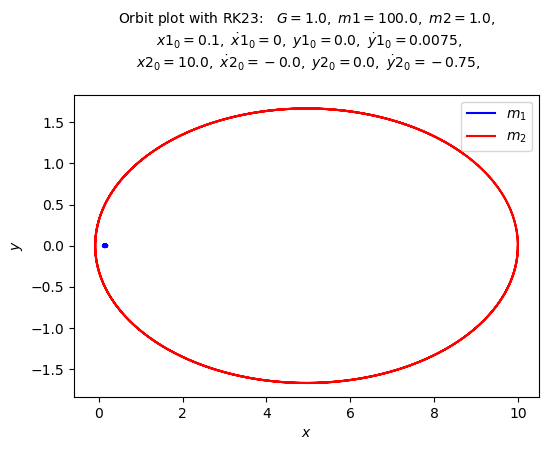

In [7]:
#plot settings
plt.subplot(1,1,1)
plt.title('Orbit plot with RK23:  ' + \
                rf' $G = {G},$' + \
                rf' $m1 = {m1:.1f},$' + \
                rf' $m2 = {m2:.1f},$' + \
                '\n' + \
                rf' $x1_0 = {x_1_0},$' + \
                rf' $\dot x1_0 = {x_1_dot_0},$' + \
                rf' $y1_0 = {y_1_0},$' + \
                rf' $\dot y1_0 = {y_1_dot_0},$' + \
                '\n' + \
                rf' $x2_0 = {x_2_0},$' + \
                rf' $\dot x2_0 = {x_2_dot_0},$' + \
                rf' $y2_0 = {y_2_0},$' + \
                rf' $\dot y2_0 = {y_2_dot_0},$' + '\n',fontsize=10)
plt.plot(x1_pts,y1_pts,'b',label='$m_1$')
plt.plot(x2_pts,y2_pts,label='$m_2$',color='red')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.show()

## Make plots of orbit using LeapFrog methods and checking the conservation of energy

In [8]:
x1_pts_LF, x1_dot_pts_LF, y1_pts_LF, y1_dot_pts_LF, x2_pts_LF, x2_dot_pts_LF, y2_pts_LF, y2_dot_pts_LF \
                           = p1.solve_ode_Leapfrog(t_pts, x_1_0, x_1_dot_0, y_1_0, y_1_dot_0, x_2_0, x_2_dot_0, y_2_0, y_2_dot_0)

C:\Users\yifu\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\yifu\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


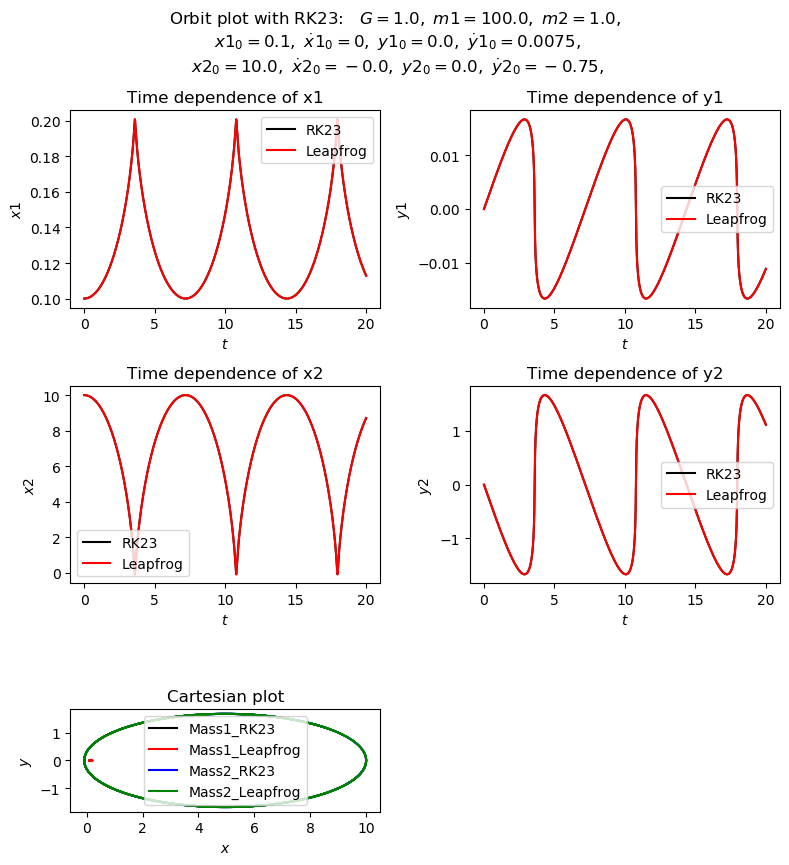

In [9]:
fig_4 = plt.figure(figsize=(8,8))

overall_title = 'Orbit plot with RK23:  ' + \
                rf' $G = {G},$' + \
                rf' $m1 = {m1:.1f},$' + \
                rf' $m2 = {m2:.1f},$' + \
                '\n' + \
                rf' $x1_0 = {x_1_0},$' + \
                rf' $\dot x1_0 = {x_1_dot_0},$' + \
                rf' $y1_0 = {y_1_0},$' + \
                rf' $\dot y1_0 = {y_1_dot_0},$' + \
                '\n' + \
                rf' $x2_0 = {x_2_0},$' + \
                rf' $\dot x2_0 = {x_2_dot_0},$' + \
                rf' $y2_0 = {y_2_0},$' + \
                rf' $\dot y2_0 = {y_2_dot_0},$' + '\n'     # \n means a new line (adds some space here)
fig_4.suptitle(overall_title, va='baseline')

ax_4a = fig_4.add_subplot(3,2,1)
ax_4a.plot(t_pts, x1_pts, color='black', label='RK23')
ax_4a.plot(t_pts, x1_pts_LF, color='red', label='Leapfrog')
ax_4a.set_xlabel(r'$t$')
ax_4a.set_ylabel(r'$x1$')
ax_4a.set_title('Time dependence of x1')
ax_4a.legend()

ax_4b = fig_4.add_subplot(3,2,2)
ax_4b.plot(t_pts, y1_pts, color='black', label='RK23')
ax_4b.plot(t_pts, y1_pts_LF, color='red', label='Leapfrog')
ax_4b.set_xlabel(r'$t$')
ax_4b.set_ylabel(r'$y1$')
ax_4b.set_title('Time dependence of y1')
ax_4b.legend()

ax_4c = fig_4.add_subplot(3,2,3)
ax_4c.plot(t_pts, x2_pts, color='black', label='RK23')
ax_4c.plot(t_pts, x2_pts_LF, color='red', label='Leapfrog')
ax_4c.set_xlabel(r'$t$')
ax_4c.set_ylabel(r'$x2$')
ax_4c.set_title('Time dependence of x2')
ax_4c.legend()

ax_4d = fig_4.add_subplot(3,2,4)
ax_4d.plot(t_pts, y2_pts, color='black', label='RK23')
ax_4d.plot(t_pts, y2_pts_LF, color='red', label='Leapfrog')
ax_4d.set_xlabel(r'$t$')
ax_4d.set_ylabel(r'$y2$')
ax_4d.set_title('Time dependence of y2')
ax_4d.legend()

ax_4e = fig_4.add_subplot(3,2,5)
ax_4e.plot(x1_pts, y1_pts, color='black', label='Mass1_RK23')
ax_4e.plot(x1_pts_LF, y1_pts_LF, color='red', label='Mass1_Leapfrog')
ax_4e.plot(x2_pts, y2_pts, color='blue', label='Mass2_RK23')
ax_4e.plot(x2_pts_LF, y2_pts_LF, color='green', label='Mass2_Leapfrog')
ax_4e.set_xlabel(r'$x$')
ax_4e.set_ylabel(r'$y$')
ax_4e.set_aspect('equal')
ax_4e.set_title('Cartesian plot')
ax_4e.legend()


fig_4.tight_layout()
#fig_4.savefig('Leapfrog_orbit_1.png', dpi=200, bbox_inches='tight')



In [10]:
E_tot_pts = p1.energy(t_pts, x1_pts, x1_dot_pts, y1_pts, y1_dot_pts, x2_pts, x2_dot_pts, y2_pts, y2_dot_pts)
E_tot_0 = E_tot_pts[0]
E_tot_rel_pts = np.abs((E_tot_pts - E_tot_0)/E_tot_0)

E_tot_pts_LF = p1.energy(t_pts, x1_pts_LF, x1_dot_pts_LF, y1_pts_LF, y1_dot_pts_LF, x2_pts_LF, x2_dot_pts_LF, y2_pts_LF, y2_dot_pts_LF)
E_tot_0_LF = E_tot_pts_LF[0]
E_tot_rel_pts_LF = np.abs((E_tot_pts_LF - E_tot_0_LF)/E_tot_0_LF)

C:\Users\yifu\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\yifu\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


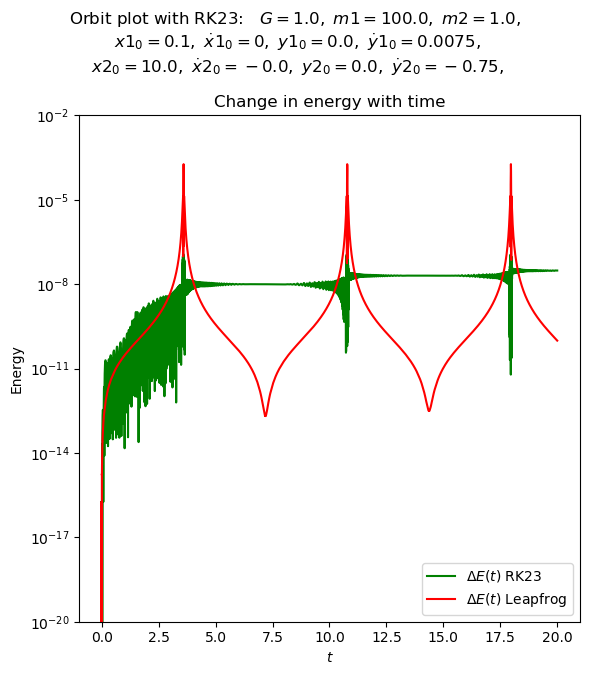

In [11]:
fig_5 = plt.figure(figsize=(6,6))
   # \n means a new line (adds some space here)
fig_5.suptitle(overall_title, va='baseline')

ax_5a = fig_5.add_subplot(1,1,1)
#ax_5a.semilogy(t_pts, np.abs(E_tot_pts), color='black', label=r'$E(t)$')
ax_5a.semilogy(t_pts, E_tot_rel_pts, 
               color='green', label=r'$\Delta E(t)$ RK23')
#ax_5a.semilogy(t_pts, E_tot_rel_pts_Euler, 
             #  color='blue', label=r'$\Delta E(t)$ Euler')
ax_5a.semilogy(t_pts, E_tot_rel_pts_LF, 
               color='red', label=r'$\Delta E(t)$ Leapfrog')
ax_5a.set_ylim(1.e-20, 1.e-2)    # (1.e-12, 5)
ax_5a.set_xlabel(r'$t$')
ax_5a.set_ylabel(r'Energy')
ax_5a.set_title('Change in energy with time')
ax_5a.legend()

fig_5.tight_layout()
fig_5.savefig('Leapfrog_energy_test_1.png', dpi=200, bbox_inches='tight')